In [14]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [15]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,dropout=0,**kwargs):
        super(Seq2SeqEncoder,self).__init__(**kwargs)
        self.embedding=nn.Embedding(vocab_size,embed_size)
        self.rnn=nn.GRU(embed_size,num_hiddens,num_layers,dropout=dropout)
    
    def forward(self,X,*args):
        X=self.embedding(X)
        X=X.permute(1,0,2)
        output,state=self.rnn(X)
        return output,state

In [16]:
encoder=Seq2SeqEncoder(vocab_size=10,embed_size=8,num_hiddens=16,num_layers=2)
encoder.eval()
X=torch.zeros((4,7),dtype=torch.long)
output,state=encoder(X)
output.shape

torch.Size([7, 4, 16])

In [17]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,dropout=0,**kwargs):
        super(Seq2SeqDecoder,self).__init__(**kwargs)
        self.embedding=nn.Embedding(vocab_size,embed_size)
        self.rnn=nn.GRU(embed_size+num_hiddens,num_hiddens,num_layers,dropout=dropout)
        self.dense=nn.Linear(num_hiddens,vocab_size)

    def init_state(self,enc_outputs,*args):
        return enc_outputs[1]
    
    def forward(self,X,state):
        X=self.embedding(X).permute(1,0,2)
        context=state[-1].repeat(X.shape[0],1,1)
        X_and_context=torch.cat((X,context),2)
        output,state=self.rnn(X_and_context,state)
        output=self.dense(output).permute(1,0,2)
        return output,state 


In [18]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [19]:
def sequence_mask(X,valid_len,value=0):
    maxlen=X.size(1)
    mask=torch.arange((maxlen),dtype=torch.float32,device=X.device)[None,:]<valid_len[:,None]
    X[~mask]=value
    return X

X=torch.tensor([[1,2,3],[4,5,6]])
sequence_mask(X,torch.tensor([1,2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [20]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [21]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [24]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

ValueError: too many values to unpack (expected 2)

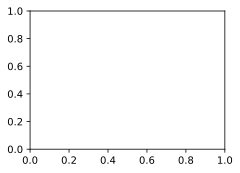

In [25]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)